In [ ]:
# Cluster Analysis of Vesicle Morphology

# 1. Introduction
# This notebook performs hierarchical cluster analysis on vesicle morphology
# data to identify distinct structural groups. The dataset comprises 20 samples,
# each characterized by a mix of numerical (e.g., 'TotalVol', 'NucVol') and
# categorical (e.g., 'Branch' type) features.

# The analysis pipeline involves:
# 1.  Data loading and preprocessing, including log transformation for numerical features.
# 2.  Calculation of a Gower distance matrix to handle the mixed data types.
# 3.  Application of hierarchical agglomerative clustering using the 'complete' linkage method.
# 4.  Determination of clusters.
# 5.  Visualization of the clustering results using a dendrogram and a 2D Multidimensional Scaling (MDS) plot.

# This notebook aims to provide a reproducible workflow for the morphological clustering presented in the accompanying paper.

In [ ]:
# 2. Setup and Dependencies
!pip3 install gower
import pandas as pd
import numpy as np
from scipy.spatial.distance import squareform
import gower
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import sys

In [ ]:
# 3. Data Loading and Definition

# The dataset for vesicle morphology is defined below. It consists of 20 samples with 10 features each, plus an ID.

# --- Data Definition ---
data = [
    ['16', 124008407040, 38677401600, 'multipolar', 234517.2827, 0, 0, 1, 746, 414, 42],
    ['14', 155282350080, 45789296640, 'bipolar', 147096.206, 0, 0, 1, 977, 256, 100],
    ['13', 168469309440, 34900439040, 'multipolar', 383703.5945, 0, 0, 1, 2609, 585, 528],
    ['18', 130380072960, 40242923520, 'multipolar', 229978.5113, 0, 0, 1, 973, 746, 67],
    ['5', 173906227200, 33367234560, 'bipolar', 265659.514, 0, 0, 1, 2294, 650, 547],
    ['20', 208749496320, 39632885760, 'multipolar', 355348.8553, 0, 0, 1, 1848, 794, 158],
    ['2', 164527994880, 43507568640, 'bipolar', 120738.7693, 4, 1, 1, 1407, 200, 186],
    ['4', 107651973120, 35105617920, 'bipolar', 63075.63401, 4, 1, 1, 756, 140, 47],
    ['10', 128919244800, 46152130560, 'bipolar', 39082.73965, 0, 0, 1, 1592, 354, 172],
    ['7', 86131230720, 28778035200, 'unipolar', 57184.89032, 0, 0, 0, 935, 606, 11],
    ['19', 108731043840, 31402782720, 'unipolar', 66012.68547, 0, 1, 0, 1410, 500, 19],
    ['9', 138603847680, 37885255680, 'unipolar', 51708.15625, 19, 1, 0, 1035, 1490, 42],
    ['8', 99765473280, 33157632000, 'unipolar', 50367.52127, 10, 1, 0, 451, 316, 11],
    ['1', 130214338560, 37502853120, 'pseudounipolar', 68757.72662, 11, 1, 0, 1201, 439, 4],
    ['11', 175661045760, 51965767680, 'pseudounipolar', 52147.47713, 4, 1, 0, 794, 1298, 19],
    ['15', 110534277120, 31753912320, 'pseudounipolar', 71870.35016, 5, 1, 0, 1791, 911, 8],
    ['12', 108910295040, 36555909120, 'pseudounipolar', 73957.49723, 10, 1, 0, 1092, 943, 20],
    ['6', 145621862400, 37960642560, 'pseudounipolar', 78434.7676, 17, 1, 0, 808, 1548, 14],
    ['17', 122137896960, 41560104960, 'pseudounipolar', 44101.97098, 5, 1, 0, 1627, 842, 20],
    ['3', 164652687360, 41093191680, 'pseudounipolar', 62134.37108, 10, 1, 0, 652, 2156, 34]
]

cols = ['ID', 'TotalVol', 'NucVol', 'Branch', 'TotalLen', 'Mic', 'Cilia', 'Handshake', 'CV', 'DCV', 'DCVH']
df = pd.DataFrame(data, columns=cols)
n_samples = len(df)

print(f"Number of samples: {n_samples}")
print("First 5 rows of the dataset:")
print(df.head().to_string())

Number of samples: 20
First 5 rows of the dataset:
   ID      TotalVol       NucVol      Branch     TotalLen  Mic  Cilia  Handshake    CV  DCV  DCVH
0  16  124008407040  38677401600  multipolar  234517.2827    0      0          1   746  414    42
1  14  155282350080  45789296640     bipolar  147096.2060    0      0          1   977  256   100
2  13  168469309440  34900439040  multipolar  383703.5945    0      0          1  2609  585   528
3  18  130380072960  40242923520  multipolar  229978.5113    0      0          1   973  746    67
4   5  173906227200  33367234560     bipolar  265659.5140    0      0          1  2294  650   547


In [ ]:
# 4. Data Preprocessing

# This section prepares the data for clustering. It involves identifying feature
# types, applying log transformations to numerical features, and ensuring
# categorical features are correctly typed.

num_cols = ['TotalVol', 'NucVol', 'TotalLen', 'Mic', 'Cilia', 'Handshake', 'CV', 'DCV', 'DCVH']
cat_cols = ['Branch']
features_for_clustering = num_cols + cat_cols

df_features = df[features_for_clustering].copy() # Create a copy for feature engineering

In [ ]:
# 4.1. Log Transformation of Numerical Features Numerical features are
# log-transformed to help normalize their distributions and reduce the impact of
# outliers or large differences in scale. For features containing zero or
# negative values, a shift is applied (`x - min(x) + 1`) before the logarithm to
# ensure all values are positive.

for col in ['TotalVol', 'NucVol', 'TotalLen', 'Mic', 'CV', 'DCV', 'DCVH']:
    if df_features[col].min() <= 0:
        df_features[col] = np.log(df_features[col] - df_features[col].min() + 1)
    else:
        df_features[col] = np.log(df_features[col])

In [ ]:
# 4.2. Set Categorical Feature Type The 'Branch' column is explicitly set to an
# object data type to be treated as categorical by the Gower distance function.

df_features[cat_cols] = df_features[cat_cols].astype(object)
categorical_features_mask = [col in cat_cols for col in df_features.columns]


In [ ]:
## 5. Gower Distance Calculation

# Gower's distance is used as it can handle mixed data types (numerical and
# categorical) simultaneously, providing a suitable dissimilarity measure for
# our heterogeneous vesicle features. The output is a condensed distance matrix.

distance_matrix = gower.gower_matrix(df_features, cat_features=categorical_features_mask)
condensed_distance_matrix = squareform(distance_matrix) # Convert to condensed form for linkage

In [ ]:
## 6. Hierarchical Clustering

# Hierarchical agglomerative clustering is performed on the Gower distance matrix.
# - **Linkage Method:** 'complete' linkage is used, which considers the maximum distance between elements of each cluster when merging.
# - **Cluster Assignment:** Clusters are formed by cutting the dendrogram at a specified distance threshold (0.4).

# Perform hierarchical/agglomerative clustering
linked = linkage(condensed_distance_matrix, method='complete')

# Assign clusters based on the distance threshold
distance_threshold = 0.4
clusters = fcluster(linked, t=distance_threshold, criterion='distance')
df['predicted_cluster'] = clusters

In [ ]:
### 6.1. Cluster Assignment Results
# The predicted cluster for each sample ID and the overall cluster sizes at the chosen distance threshold are printed below.

output_df = df[['ID', 'predicted_cluster']].rename(columns={'predicted_cluster': 'Predicted Cluster'})
output_df_sorted = output_df.sort_values(by='Predicted Cluster')

print(f"\nPredicted Clusters (Sorted by Cluster Number, distance <= {distance_threshold})")
print(output_df_sorted.to_string(index=False))

num_clusters_found = len(output_df_sorted['Predicted Cluster'].unique())
print(f"\nNumber of clusters found at distance {distance_threshold}: {num_clusters_found}")

print("\nCluster Sizes:")
print(output_df_sorted['Predicted Cluster'].value_counts().sort_index())


Predicted Clusters (Sorted by Cluster Number, distance <= 0.4)
ID  Predicted Cluster
 2                  1
 4                  1
11                  2
15                  2
 8                  2
 1                  2
 9                  2
12                  2
 3                  2
17                  2
 6                  2
 7                  3
19                  3
20                  4
 5                  4
18                  4
10                  4
13                  4
16                  4
14                  4

Number of clusters found at distance 0.4: 4

Cluster Sizes:
Predicted Cluster
1    2
2    9
3    2
4    7
Name: count, dtype: int64


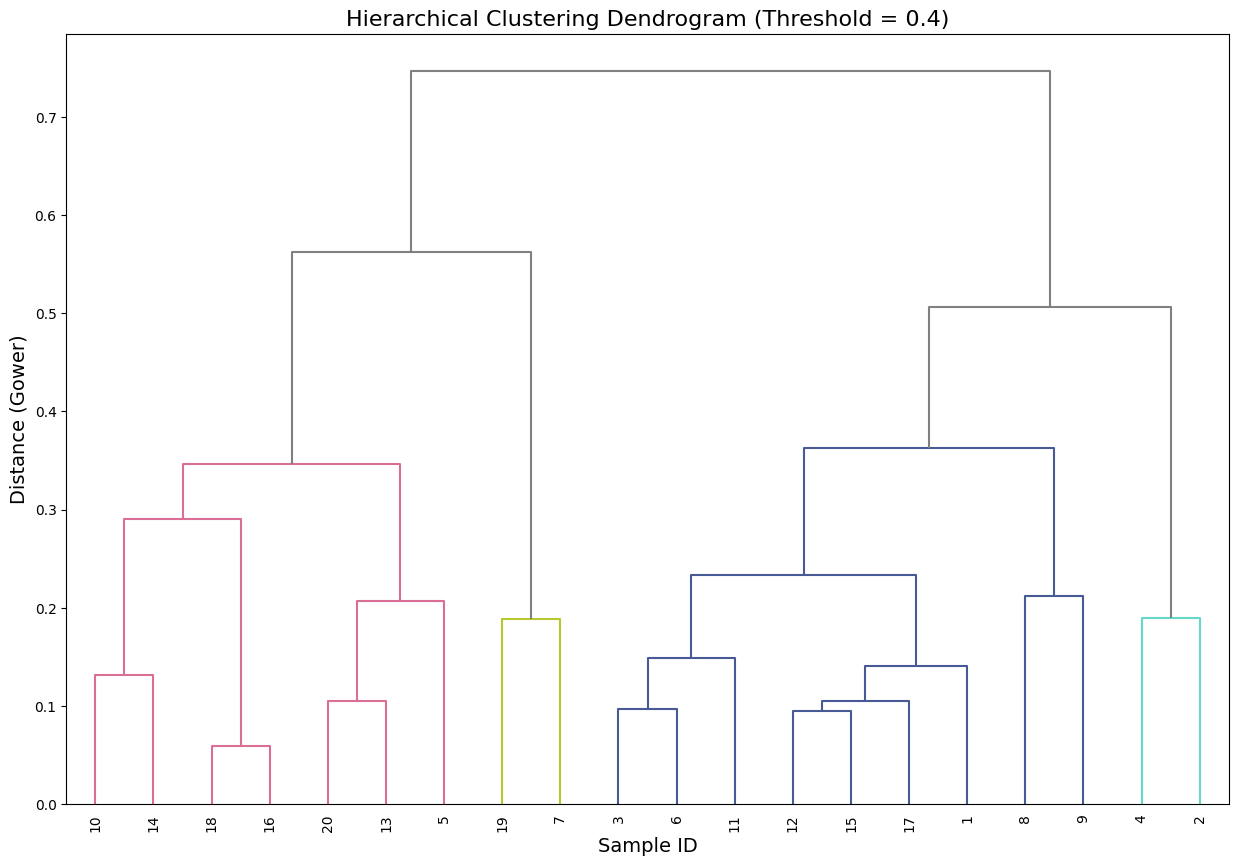

In [ ]:
# ## 7. Visualization

# The clustering results are visualized using a dendrogram and a 2D MDS plot.

# 7.1. Dendrogram The dendrogram visually represents the hierarchical
# clustering. Branches are colored according to the clusters formed at the
# distance threshold of 0.4. The helper functions `get_one_leaf` and
# `get_link_color_simple` are defined for this custom coloring.

cluster_labels = sorted(output_df_sorted['Predicted Cluster'].unique())
# Define a color palette for the clusters
hex_colors = ['#64D9C9', '#485A96', '#B7C72C', '#DB6E96']
color_map = {label: hex_colors[i % len(hex_colors)] for i, label in enumerate(cluster_labels)}
default_link_color = '#808080' # Gray for links above threshold or unassigned

memo_leaf = {} # Memoization for get_one_leaf

def get_one_leaf(node_id):
    """
    Helper function to get a representative leaf index from a cluster node.
    Used for consistent coloring of dendrogram branches within the same final cluster.
    """
    if node_id in memo_leaf:
        return memo_leaf[node_id]
    if node_id < n_samples: # Leaf node
        memo_leaf[node_id] = node_id
        return node_id
    else: # Internal node
        link_idx = int(node_id - n_samples)
        child1_id = int(linked[link_idx, 0]) # Get one of the children
        leaf_idx = get_one_leaf(child1_id)
        memo_leaf[node_id] = leaf_idx
        return leaf_idx

def get_link_color_simple(cluster_id):
    """
    Determines the color for a dendrogram link based on whether the merged cluster
    is below the predefined distance_threshold.
    """
    link_idx = int(cluster_id - n_samples) # Convert cluster_id to index in 'linked' array
    # Basic check for validity, though dendrogram usually passes valid IDs
    if link_idx < 0 or link_idx >= linked.shape[0]:
        return default_link_color

    merge_distance = linked[link_idx, 2] # The distance at which this merge occurred

    if merge_distance > distance_threshold:
        return default_link_color # Color gray if merge is above threshold
    else:
        # If below threshold, color according to the final cluster of one of its leaves
        leaf_index = get_one_leaf(cluster_id)
        final_cluster_label = clusters[leaf_index] # 'clusters' is from fcluster
        return color_map.get(final_cluster_label, default_link_color)

# Plot the dendrogram
plt.figure(figsize=(15, 10))
memo_leaf.clear() # Clear memoization cache before use

dendrogram_result = dendrogram(
    linked,
    orientation='top',
    labels=df['ID'].values,
    distance_sort='descending', # Show larger clusters forming first on one side
    show_leaf_counts=True,
    link_color_func=lambda k: get_link_color_simple(k),
    above_threshold_color=default_link_color # Color for links above the threshold
)

# Add plot enhancements
plt.title(f'Hierarchical Clustering Dendrogram (Threshold = {distance_threshold})', fontsize=16)
plt.xlabel('Sample ID', fontsize=14)
plt.ylabel('Distance (Gower)', fontsize=14)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)

# Optional: Save the figure for your paper
# plt.savefig("dendrogram_for_paper.png", dpi=300, bbox_inches='tight')
plt.show()

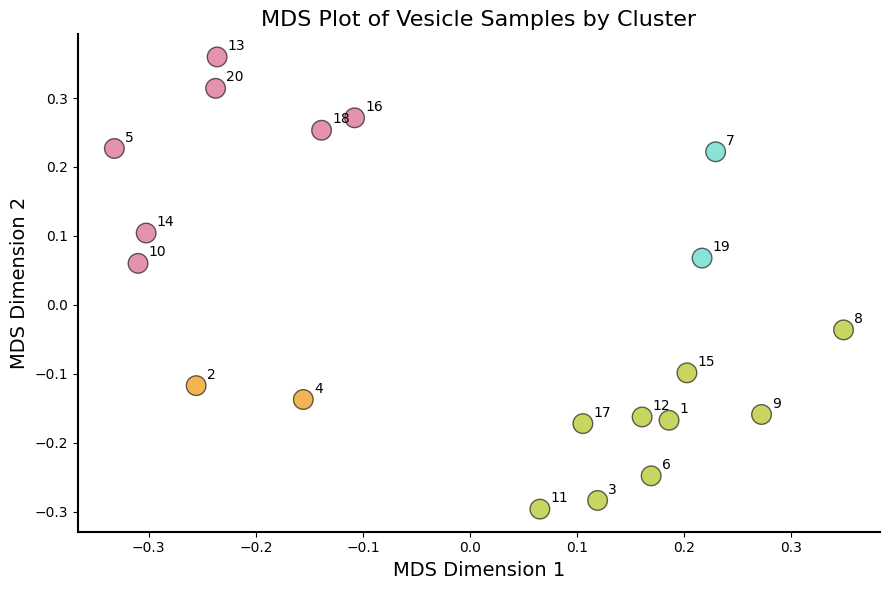

In [ ]:
# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress=False)
mds_coords = mds.fit_transform(distance_matrix) # Use the full Gower distance matrix

# Create DataFrame for MDS results
mds_df = pd.DataFrame(mds_coords, columns=['MDS1', 'MDS2'], index=df.index)
mds_df['predicted_cluster'] = df['predicted_cluster'] # Add cluster assignments from previous step
mds_df['ID'] = df['ID'] # Add IDs for labeling

# Plot MDS results
fig, ax = plt.subplots(figsize=(9, 6))

# Define colors and transparency
face_alpha = 0.75
edge_alpha = 0.6
edge_base_color = 'black'

# Map predicted clusters to colors
cluster_colors_mapped = mds_df['predicted_cluster'].map(color_map).fillna(default_link_color)
face_colors_rgba = [mcolors.to_rgba(hex_color, alpha=face_alpha) for hex_color in cluster_colors_mapped]
edge_color_rgba = mcolors.to_rgba(edge_base_color, alpha=edge_alpha)

# Scatter plot
ax.scatter(mds_df['MDS1'], mds_df['MDS2'], c=face_colors_rgba, s=200, edgecolors=edge_color_rgba, linewidths=1)
ax.tick_params(axis='both', which='major', labelsize=10)

# Annotate points with IDs
for i, txt in enumerate(mds_df['ID']):
  ax.text(mds_df['MDS1'].iloc[i] + 0.01, mds_df['MDS2'].iloc[i] + 0.01, txt, fontsize=10) # Adjust offset as needed

# Add plot enhancements
ax.set_title('MDS Plot of Vesicle Samples by Cluster', fontsize=16)
ax.set_xlabel('MDS Dimension 1', fontsize=14)
ax.set_ylabel('MDS Dimension 2', fontsize=14)

# Customize spines
axis_thickness = 1.5
ax.spines['left'].set_linewidth(axis_thickness)
ax.spines['bottom'].set_linewidth(axis_thickness)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

# Optional: Save the figure for your paper
# plt.savefig("mds_plot_for_paper.png", dpi=300, bbox_inches='tight')
plt.show()